In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.hpatch import *
from utils.tasks import *
from utils.misc import *
import os
import time
import dill
import numpy as np
import sys
__doc__ = r"""Evaluation code for the HPatches homography patches dataset.

Usage:
  hpatches_eval.py (-h | --help)
  hpatches_eval.py --version
  hpatches_eval.py --descr-name=<> --task=<>... [--descr-dir=<>] [--results-dir=<>] [--split=<>] [--dist=<>] [--delimiter=<>] [--pcapl=<>]

Options:
  -h --help         Show this screen.
  --version         Show version.
  --descr-name=<>   Descriptor name, e.g. sift
  --descr-dir=<>    Descriptor results root folder. [default: {root}/data/descriptors]
  --results-dir=<>  Results root folder. [default: results]
  --task=<>         Task name. Valid tasks are {verification,matching,retrieval}.
  --split=<>        Split name. Valid are {a,b,c,full,illum,view}. [default: a]
  --dist=<>         Distance name. Valid are {L1,L2}. [default: L2]
  --delimiter=<>    Delimiter used in the csv files. [default: ,]
  --pcapl=<>        Compute results for pca-power law descr. [default: no]

For more visit: https://github.com/hpatches/
"""
from utils.docopt import docopt

In [29]:
DESCR='HardNet6Br'
argv = [ f'--descr-name={DESCR}', '--task=matching', '--split=view', '--delimiter=,']


In [30]:
opts = docopt(__doc__, argv)

DIR = !pwd
DIR = DIR[0]

descr_dir = opts['--descr-dir'].format(
    root=os.path.normpath(os.path.join(DIR, ".."))
)
path = os.path.join(descr_dir, opts['--descr-name'])

try:
    assert os.path.exists(path)
except:
    print("%r does not exist." % (path))

results_dir = opts['--results-dir']
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

descr_name = opts['--descr-name']
print('\n>> Running HPatch evaluation for %s' % blue(descr_name))

descr = load_descrs(path,dist=opts['--dist'],sep=opts['--delimiter'])

with open(os.path.join(tskdir, "splits", "splits.json")) as f:
    splits = json.load(f)

splt = splits[opts['--split']]


>> Running HPatch evaluation for HardNet6Br
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.


In [31]:
def get_nuisance_fname(root, seq, hardness, idx, nuis='overlaps'):
    return os.path.join(root, f'{seq}/{hardness}{idx}.{nuis}')
NUISS = ['trjitter', 'scjitter', 'rotjitter', 'overlaps', 'anisjitter']

In [32]:
def eval_matching(descr,split):
    print('>> Evaluating %s task' % green('matching'))
    start = time.time()
    results = defaultdict(lambda: defaultdict(lambda:defaultdict(dict)))
    pbar = tqdm(split['test'])
    res = {"correct": []}
    for k in NUISS:
        res[k] = []
    for seq in pbar:
        d_ref = getattr(descr[seq], 'ref').astype(np.float32)
        gt_l = np.arange(d_ref.shape[0])
        for t in tp:
            for i in range(1,6):
                d = getattr(descr[seq], t+str(i)).astype(np.float32)
                for nius in NUISS:
                    res[nius].append(np.loadtxt(get_nuisance_fname('../data/hpatches-release',seq, t, i, nius)).reshape(-1,1))
                D = dist_matrix(d_ref,d,descr['distance'])
                idx = np.argmin(D,axis=1)
                m_l = np.equal(idx,gt_l)
                res["correct"].append(m_l.astype(np.float32).reshape(-1,1))
                results[seq][t][i]['sr'] = np.count_nonzero(m_l) / float(m_l.shape[0])
                m_d = D[gt_l,idx]
                pr,rc,ap = metrics.pr(-m_d,m_l,numpos=m_l.shape[0])
                results[seq][t][i]['ap'] = ap
                results[seq][t][i]['pr'] = pr
                results[seq][t][i]['rc'] = rc
                # print(t,i,ap,results[seq][t][i]['sr'])
    end = time.time()
    print(">> %s task finished in %.0f secs  " % (green('Matching'),end-start))
    res_out = {}
    for k, v in res.items():
        res_out[k] = np.concatenate(v,axis=0)
    np.savez(f"{DESCR}_detailed", res_out)
    return results


In [33]:
res = eval_matching(descr,splt)

  0%|          | 0/59 [00:00<?, ?it/s]

>> Evaluating matching task


100%|██████████| 59/59 [00:28<00:00,  2.10it/s]

>> Matching task finished in 28 secs  


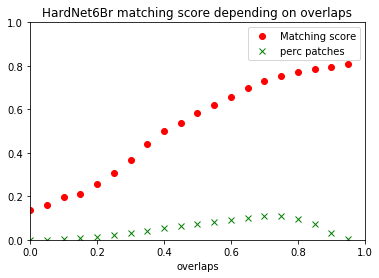

In [34]:
fname_res = f"{DESCR}_detailed.npz"
res_dict = np.load(fname_res, allow_pickle=True)['arr_0'].item()
def plot_overlap_res(res_dict, by='overlaps'):
    x = np.abs(res_dict[by])
    idxs = np.argsort(x[:,0])[::-1]
    x = x[idxs]
    y = res_dict['correct'][idxs]
    xx = []
    yy = []
    perc = []
    limits = np.min(x), np.max(x)+1e-4
    num = 20
    range1 = np.linspace(*limits, num+1)
    for idx, th in enumerate(range1):
        if idx == len(range1) - 1:
            break
        th_next =range1[idx+1]
        mask = (x >= th) & (x < th_next)
        acc =  np.mean(y[mask])
        perc_patches = mask.astype(np.float).mean()
        xx.append(th)
        perc.append(perc_patches)
        yy.append(acc)
    plt.figure()
    plt.plot(xx,yy, 'ro')
    plt.plot(xx,perc, 'gx')
    plt.title(f'{DESCR} matching score depending on {by}')
    plt.xlabel(by)
    plt.ylim([0,1])
    plt.xlim(limits)
    plt.legend(['Matching score', 'perc patches'])
    return
plot_overlap_res(res_dict, 'overlaps')

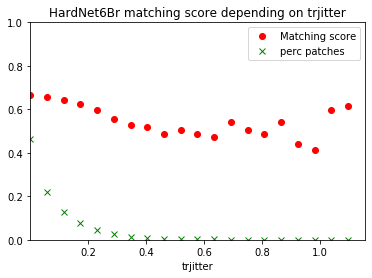

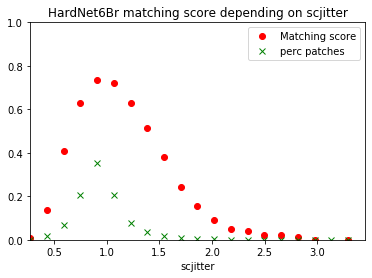

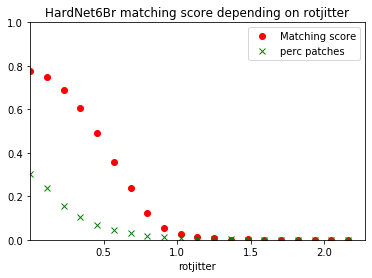

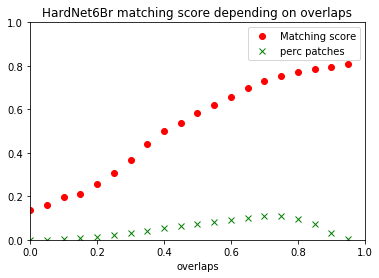

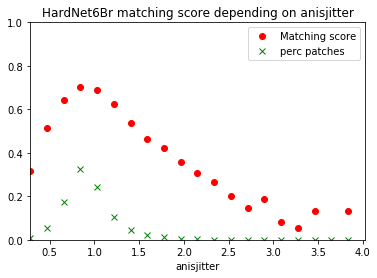

In [35]:
plt.close('all')
for factor in NUISS:
    plot_overlap_res(res_dict, factor)